# Project: Investigating gun ownership data in the USA

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> The data sets chosen for this analysis were from the U.S. Census Bureau and the FBI's National Criminal Background Check System. The criminal background check is done when trying to legally purchase a firearm in the United States and this data set shows the number of background checks for various firearm and explosive purchase inquiries and re-inquiries. The Census bureau data contains several topics and questions asked but I will only be using the population estimate for 2016 and the poverty percentage of that population for each state for examination here.

> The project will explore the number of total inquiries for gun purchase by state and try to expose trends per capita for each state. Also, I will consider if there were insights from the number of inquiries when comparied to states with higher poverty rates.

In [26]:
#importing necessary packages and allowing visualizations to be shown using %matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

>The census and gun data are mostly unrelated and do not line up perfectly in terms of time frame. Also, 
 the more recent population data(which all of the rest is based upon) is an estimate. These things should be considered 
 when deciding on questions. Also, the census data is primarily strings and some rows vary between using decimal percentage 
 indicators and the #% format. 
 To start I chose two rows from the census DF I wanted to focus on regarding overall population estimate and percentage of 
 population below poverty level. I reduced the df to these rows and then transposed the df so that the index is the state name
 in question. This is so I may merge the two data sets later. Then I cleaned up some unnecessary rows and converted all the 
 string values to int or float. The population contained commas for the numeric values and needed to be removed before 
 converting. Also the percentage column contained % which must be removed. Also, some values in the % row were decimal 
 percentages and others were not. I grouped by these two sets and made them consistent by dividing the non decimal percentages
 by 100. Finally, after converting to numeric values, I added a column that multiplies the percentages by the estimated 
 population to find the estimated population below the poverty line. The gun data set was much cleaner but did have some 
 issues. The values were for several years while the census data was only from 2016 and 2010 exclusively. To remedy this issue
 I aggregated all the 2016 gun data by state. There were also a few US territories included in the gun data that were not 
 in the census data. These rows were removed. I considered adding the district of columbia's data in a state's because it was
 likely part of the census but was unsure which would be most logical. The data for district of columbia was minimal but 
 should be considered in my final statements. I then merged the two data sets using an outer join so I retain all columns 
 and rows.

### General Properties

In [27]:
#setting up both data sets to be cleaned
df1 = pd.read_csv('U.S. Census Data.csv')
df2 = pd.read_excel('gun_data.xlsx')
df1.info() # found that the census data contained no null values in the needed columns
df2.info() #found that gun data has certain columns that are very sparse
#once the dfs are cleaned and only contain necessary columns we will look again at nulls and outliers
df1.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 52 columns):
Fact              80 non-null object
Fact Note         28 non-null object
Alabama           65 non-null object
Alaska            65 non-null object
Arizona           65 non-null object
Arkansas          65 non-null object
California        65 non-null object
Colorado          65 non-null object
Connecticut       65 non-null object
Delaware          65 non-null object
Florida           65 non-null object
Georgia           65 non-null object
Hawaii            65 non-null object
Idaho             65 non-null object
Illinois          65 non-null object
Indiana           65 non-null object
Iowa              65 non-null object
Kansas            65 non-null object
Kentucky          65 non-null object
Louisiana         65 non-null object
Maine             65 non-null object
Maryland          65 non-null object
Massachusetts     65 non-null object
Michigan          65 non-null object
Minnesota

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"


### Data Cleaning 

In [28]:
census_df = df1.iloc[[0, 49]] #reduced census data to rows 0 and 49 because these are the only ones used in analysis
census_df.drop(['Fact Note'], axis=1, inplace=True) #dropped column because it was irrelevant and would prevent clean joining of two data sets
census_df = census_df.transpose()#transposed so that the state column can be made join column later
census_df = census_df.iloc[1:] #got rid of index column that was made when transposing
census_df = census_df.rename({0: 'July_2016_pop_est', 49: 'poverty_percentage'}, axis='columns') #renaming columns to something shorter and more ingestible
census_df['July_2016_pop_est'] = census_df['July_2016_pop_est'].str.replace(',', '') #cleaning population rows to remove commas so it may be convertied to numeric
census_df['poverty_percentage'] = census_df['poverty_percentage'].str.replace('%', '') #cleaning percentage rows to remove % signs so it may be converted to numeric
census_df = census_df.apply(pd.to_numeric) #changing the strings so we can perform math functions on data
census_df['poverty_percentage'] = census_df['poverty_percentage'].apply(lambda x: x/100 if x>1 else x) #converting to decimal percent
census_df['population_est_poverty'] = census_df['July_2016_pop_est'] * census_df['poverty_percentage'] #estimating the number of people under poverty criteria per state
census_df.index.name = 'state' #naming the index for join of data sets later

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [29]:
gun_df = df2[(df2['month'] >= '2016-01') & (df2['month'] < '2017-01')] #filtering by year because the gun data contained several years of data with sparse reporting for many states. Chose 2016 because it lined up with year from census data
gun_df.set_index('state', inplace=True) #made state the index to join with other data
gun_df = gun_df.groupby(['state']).sum() #taking monthly data for columns and converting it into yearly
gun_df.drop(['prepawn_handgun', 'prepawn_long_gun', 'prepawn_other',
       'redemption_handgun', 'redemption_long_gun', 'redemption_other',
       'returned_handgun', 'returned_long_gun', 'returned_other',
       'rentals_handgun', 'rentals_long_gun', 'private_sale_handgun',
       'private_sale_long_gun', 'private_sale_other',
       'return_to_seller_handgun', 'return_to_seller_long_gun',
       'return_to_seller_other'], axis=1, inplace=True) #these columns were removed because they were highly variate from state to state and mostly zeroes. Their values were still captured in the totals column and that was the focus of report
gun_df.drop(['Guam', 'District of Columbia', 'Puerto Rico', 'Mariana Islands', 'Virgin Islands'], inplace=True) #dropped US territories that were not in census data

In [30]:
#the data is now clean and ready to be combined. An outer join was chosen so that all rows are kept
df_combined = gun_df.merge(census_df, left_on='state', right_on='state', how='outer')
df_combined.describe() #found that while some states had outliers, I chose to include the outliers in my exploration because of 
# the relatively small data set and the general unknown aspect of the gun inquiries. The check laws vary from state to state and 
# the purpose of my exploration is to find new areas of interest.
df_combined.info() #there were no no null values once the data was cleaned


<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 11 columns):
permit                    50 non-null float64
permit_recheck            50 non-null float64
handgun                   50 non-null float64
long_gun                  50 non-null float64
other                     50 non-null float64
multiple                  50 non-null int64
admin                     50 non-null float64
totals                    50 non-null int64
July_2016_pop_est         50 non-null int64
poverty_percentage        50 non-null float64
population_est_poverty    50 non-null float64
dtypes: float64(8), int64(3)
memory usage: 4.7+ KB


<a id='eda'></a>
## Exploratory Data Analysis


### Do states with higher population also have higher gun purchase attempts? Do they also show a certain gun type is more popular in more populated areas?

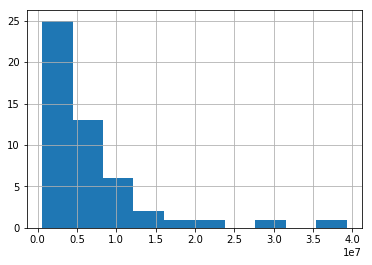

In [31]:
#before looking at the gun purchase inquiries by population level we need to make a logical breakup of population levels.
#this is done using df.describe() for our population estimate column. The bins are set to be the different quartile edges.
df_combined.describe().July_2016_pop_est
bin_edges = [5.855009e+05, 1.850106e+06, 4.559320e+06, 7.198768e+06, 3.925003e+07]
bin_names = ['low_pop', 'mod_low', 'mod_high', 'high']# made new column to group the populations in logical subsections
df_combined['pop_level'] = pd.cut(df_combined['July_2016_pop_est'], bin_edges, labels=bin_names)
#Now we can explore the population estimates visually to get a better idea of the attributes
df_combined.July_2016_pop_est.hist()
#the estimates are significantly skewed to the left(meaning most populations fall in a simlar group with a few outliers)

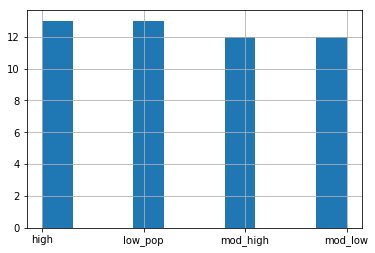

In [32]:
#however when we explore the bins we made they contain roughly the same number of items and can be used for our questions
df_combined.pop_level.hist()

Text(0,0.5,'Gun Purchase Inquiry per Capita')

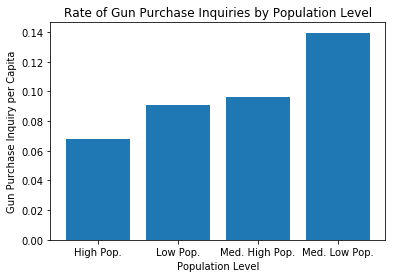

In [33]:
#now we creat a rate called 'guns_per_capita' to explore against the population level zones made previously
df_combined['guns_per_capita'] = df_combined['totals'] / df_combined['July_2016_pop_est'] #made new column for rate
df_combined.groupby('pop_level').mean().guns_per_capita #looked at the mean gun inquiries per capita to seperate into 4 equally sized bins
labels = ['Low Pop.', 'Med. Low Pop.', 'Med. High Pop.', 'High Pop.']
values = [0.090627, 0.139522, 0.096101, 0.067625] #used df.describe() to get values for bins
plt.bar(labels, values)
plt.title("Rate of Gun Purchase Inquiries by Population Level")
plt.xlabel("Population Level")
plt.ylabel("Gun Purchase Inquiry per Capita")

Text(0.5,0,'Population Level')

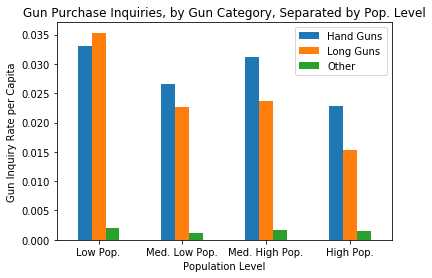

In [34]:
#now we explore this idea further by creating rates of qun inquiry by gun type and compare to the population levels
df_combined['handguns_per_capita'] = df_combined['handgun'] / df_combined['July_2016_pop_est']
df_combined['long_guns_per_capita'] = df_combined['long_gun'] / df_combined['July_2016_pop_est']
df_combined['other_guns_per_capita'] = df_combined['other'] / df_combined['July_2016_pop_est']
handgun = [0.033024, 0.026644, 0.031170, 0.022871] #used df.describe() to get values for bins
longgun = [0.035310, 0.022627, 0.023665, 0.015234]
other = [0.001967, 0.001171, 0.001752, 0.001453]
df_plot = pd.DataFrame({'Hand Guns': handgun, 'Long Guns': longgun, 'Other': other}, index=labels)
chart = df_plot.plot.bar(title='Gun Purchase Inquiries, by Gun Category, Separated by Pop. Level', rot=0)
plt.ylabel('Gun Inquiry Rate per Capita')
plt.xlabel('Population Level')

### Does poverty level indicate anything about gun ownership?

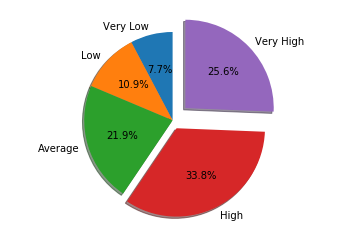

In [35]:
#nothing very significant was revealed by doing this... what if we look at gun inquiries based upon a states percentage of the
#population below the poverty line?
df_combined.sort_values(by=['poverty_percentage']) #found states with highest poverty rates
bin_edges = [0.072, 0.108, 0.122, 0.142, 0.159, 0.209] #split into 5 evenly sized bins of ten states each
bin_names = ['very_low', 'low', 'med', 'high', 'very_high']
df_combined['poverty_level'] = pd.cut(df_combined['poverty_percentage'], bin_edges, labels=bin_names)#created new column with poverty levels
df_combined.groupby('poverty_level').sum().totals #found number of total inquiries by the poverty zones made
total_gun_inquiries = df_combined.totals.sum() #values used to determine what % each bin makes up of the whole in terms of gun inquiries
labels = ['Very Low', 'Low', 'Average', 'High', 'Very High']
#now we convert to percentages in the next line to communicate percentages more clearly
values = [2119158/total_gun_inquiries*100, 2994627/total_gun_inquiries*100, 5996632/total_gun_inquiries*100, 9269874/total_gun_inquiries*100, 7025258/total_gun_inquiries*100]
explode = (0, 0, 0, 0.1, 0.2) #accentuate the largest slices
fig1, ax1 = plt.subplots()
ax1.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

<a id='conclusions'></a>
## Conclusions

> Limitations to my study were that my two data sets did not line up exactly. The gun data had many many years to explore while the census data was a report of one year for population only and an estimate for another. Estimates increase the risk of innacuracy. Also, most of the census data was very specific questions about the population that weren't fully relatable to gun purchase inquiries. Also, the gun data is not very clear. I assume it does not indicate whether a gun is actually purchased or denied. It does not capture illegal purchases or unchecked purchases and it doesn't actually indicate how many guns may actually be in a state at a given time. Finally, the gun data points are just not totally clear about their meaning for each column and it is difficult to assume what they mean based on their naming. The place where the data was extracted gave no more information than what was shared in this report.

> When exploring the gun and census data I found some interesting things that should be expanded upon with further research. In 2016 over 1/4 of gun inquiries were requested by people that are from states with the highest poverty rates for that year(ten highest poverty rates). Nearly 60% were in the 20 states with the highest poverty rate. It would require much further inspection but this might be an area of interest. However, when exploring the number of gun inquiries by more densely populated areas in 2016 there was not much of interest. Possibly the most interesting point was the high number of gun inquiry rates per capita being so high comparitively in terms of hand guns and long guns. I would wish to explore further with more data from both of these areas of interest.

In [36]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0